# Import data
Import sequenced data from a `json` file.

In [249]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import random
pd.options.mode.chained_assignment = None
%matplotlib inline

In [250]:
def get_data():
    data_file = 'fightmetric/data/imputed.json'
    frame = pd.read_json(data_file)
    return frame
    

def get_label(event_date):
    event_date = event_date.date()
    if event_date >= date(2015, 1, 1):
        return 'test'
    return 'train'


def train_test_split(data):
    data = data[(data['result'] == 'Win') | (data['result'] == 'Loss')]
    data['set'] = data['date'].apply(get_label)
    train = data.loc[data['set'] == 'train']
    test = data.loc[data['set'] == 'test']
    valid = data.loc[data['set'] == 'valid']
    assert len(data) == len(train) + len(test) + len(valid)
    
    return train, test, valid

def split(data):
    data = data[(data['result'] == 'Win') | (data['result'] == 'Loss')]
    y = data['result'].map({'Win': 1, 'Loss': 0})
    x = data.drop(['result'], axis=1)
    return x, y

# Data exploration

In [251]:
data = get_data()
train, test, valid = train_test_split(data)

In [252]:
keys = ['body', 'clinch', 'distance', 'ground', 'head', 
        'knockouts', 'leg', 'sig. str', 'submissions', 'td', 'total str.']
for key in keys:
    landed = train['fighter'].apply(lambda x: x['stats'][key]['landed'])
    thrown = train['fighter'].apply(lambda x: x['stats'][key]['thrown'])
    print(f"'{key}': {(landed.sum() / thrown.sum())},")

'body': 0.7473003379873279,
'clinch': 0.6571087641322761,
'distance': 0.3455062095114903,
'ground': 0.6262766775935562,
'head': 0.3628908924004376,
'knockouts': 0.9343414859964508,
'leg': 0.7791716658682076,
'sig. str': 0.44421437047191575,
'submissions': 0.2572297418162304,
'td': 0.4768224733013465,
'total str.': 0.5933736946615897,


In [253]:
for key in keys:
    avoided = train['fighter'].apply(lambda x: x['stats'][key]['avoided'])
    received = train['fighter'].apply(lambda x: x['stats'][key]['received'])
    total = avoided + received
    print(f"'{key}': {(avoided.sum() / total.sum())},")

'body': 0.2876221212962016,
'clinch': 0.3741905657569338,
'distance': 0.6827144917612437,
'ground': 0.3980045751295038,
'head': 0.6875411808215335,
'knockouts': 0.3100940975192472,
'leg': 0.24724693306549966,
'sig. str': 0.6002153958424062,
'submissions': 0.8462684763784285,
'td': 0.6195488480886924,
'total str.': 0.4412454210775378,


# Data preparation

In [254]:
data = get_data()
train, test, valid = train_test_split(data)
datasets = [train, test]
# pprint(data.iloc[random.randint(0, len(data))]['fighter'])

In [255]:
def offense_accuracy(fighter, key):
    landed = fighter['stats'][key]['landed']
    total = fighter['stats'][key]['thrown']
    
    return landed / (total + .1)

    
def defense_accuracy(fighter, key): 
    avoided = fighter['stats'][key]['avoided']
    received = fighter['stats'][key]['received']
    total = avoided + received
    
    return avoided / (total + .1)

    
def accuracy(dataset, key):
    
    def calc(fighter, key):
        offense = offense_accuracy(fighter, key)
        defense = defense_accuracy(fighter, key)
        return offense + defense
        
    
    fighter = dataset['fighter'].apply(lambda x: calc(x, key))
    opponent = dataset['opponent'].apply(lambda x: calc(x, key))
    return fighter - opponent


def probability(positive, both):
    try:
        return positive / both
    except Exception:
        return 0.5

    
def safe_divide(first, second):
    try:
        return first / second
    except Exception:
        return 1.0

In [256]:
for dataset in datasets:
    """
    Historical features
    """
    # Probabilities
    fighter = dataset['fighter'].apply(lambda x: probability(x['history']['wins'], x['history']['fights']))
    opponent = dataset['opponent'].apply(lambda x: probability(x['history']['wins'], x['history']['fights']))
    dataset['Win probability'] = fighter - opponent
    # Streak wins minus losses
    fighter = dataset['fighter'].apply(lambda x: x['streak']['wins'] - x['streak']['losses'])
    opponent = dataset['opponent'].apply(lambda x: x['streak']['wins'] - x['streak']['losses'])
    dataset['Streak'] = fighter - opponent
    # Time spent in the octagon
    fighter = dataset['fighter'].apply(lambda x: x['history']['time'])
    opponent = dataset['opponent'].apply(lambda x: x['history']['time'])
    dataset['Time'] = fighter - opponent
    # Avg position in the fightcard
    fighter = dataset['fighter'].apply(lambda x: x['history']['position'] / 
                                                (x['history']['fights'] + .1))
    opponent = dataset['opponent'].apply(lambda x: x['history']['position'] / 
                                                  (x['history']['fights'] + .1))
    dataset['Avg position'] = fighter - opponent
    # Is first fight
    dataset['Is first'] = dataset['fighter'].apply(lambda x: x['history']['fights'] > 0).astype(int)
    
    
    """
    Physiacal features
    """
    # Difference in age
    fighter = dataset['fighter'].apply(lambda x: x['age'])
    opponent = dataset['opponent'].apply(lambda x: x['age'])
    dataset['Age'] = fighter - opponent
    # Difference in reach
    fighter = dataset['fighter'].apply(lambda x: x['reach'])
    opponent = dataset['opponent'].apply(lambda x: x['reach'])
    dataset['Reach'] = fighter - opponent
    # Knockouts
    fighter = dataset['fighter'].apply(lambda x: x['stats']['knockouts']['landed'])
    opponent = dataset['opponent'].apply(lambda x: x['stats']['knockouts']['landed'])
    dataset['Knockouts'] = fighter - opponent
    # Submissions
    fighter = dataset['fighter'].apply(lambda x: x['stats']['submissions']['landed'])
    opponent = dataset['opponent'].apply(lambda x: x['stats']['submissions']['landed'])
    dataset['Submissions'] = fighter - opponent
    
    
    
    """
    Performance features
    """
    dataset['Striking'] = accuracy(dataset, 'sig. str')
    dataset['Takedowns'] = accuracy(dataset, 'td')

# Feature selection and scaling

In [257]:
from sklearn.preprocessing import Imputer, StandardScaler    

for dataset in datasets:
    for key in ['date', 'event', 'fighter', 'link', 'opponent', 
                'location', 'method', 'referee', 'set']:
        if key in dataset:
            dataset.drop([key], axis=1, inplace=True)
            

train = train.replace([np.inf, -np.inf], np.nan)
xtrain, ytrain = split(train)
imputer = Imputer(strategy='median')
imputer.fit(xtrain)
xtrain = pd.DataFrame(imputer.transform(xtrain), columns=xtrain.columns)
assert len(xtrain) == len(ytrain) == len(train)

test = test.replace([np.inf, -np.inf], np.nan) 
xtest, ytest = split(test)
xtest = pd.DataFrame(imputer.transform(xtest), columns=xtest.columns)
assert len(test) == len(ytest) == len(xtest)


scaler = StandardScaler()
scaler.fit(xtrain)

xtrain = pd.DataFrame(scaler.transform(xtrain), columns=xtrain.columns)
xtest = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns)

In [258]:
for dataset in datasets:
    print(f'Dataset of {len(list(dataset.columns))} features with {len(dataset)} rows.')
    
xtrain.tail()

Dataset of 12 features with 9282 rows.
Dataset of 12 features with 2554 rows.


,Win probability,Streak,Time,Avg position,Is first,Age,Reach,Knockouts,Submissions,Striking,Takedowns
9277,-0.627380,-0.405441,-0.707055,-1.211207,-1.939072,-0.199270,-0.769245,-1.544806,0.000000,-1.836196,-1.349384
9278,-1.463886,0.000000,0.108441,-0.526321,0.515711,0.000000,-1.153867,-0.386201,0.000000,-0.605722,0.563001
9279,-2.927772,-1.621763,0.031608,0.282416,0.515711,0.597809,-2.692357,0.000000,-0.435536,-0.669989,-0.607997
9280,-0.292777,-0.810881,-0.727479,-2.442069,-1.939072,-0.398539,0.000000,0.000000,-0.871072,-1.604566,-0.956377
9281,-1.254760,0.000000,-0.897678,0.774565,0.515711,-0.597809,0.000000,-0.386201,0.000000,-0.387814,-1.303593


# Model selection

In [259]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(xtrain, ytrain)

print(f'LogisticRegression training {accuracy_score(ytrain, model.predict(xtrain))*100:.2f}%')
print(f'LogisticRegression testing {accuracy_score(ytest, model.predict(xtest))*100:.2f}%')

LogisticRegression training 65.03%
LogisticRegression testing 60.45%


In [260]:
feats = {feature: importance for feature, importance in zip(xtrain.columns, model.coef_[0])}
importances = pd.DataFrame.from_dict(feats, orient='index')
importances = importances.rename(columns={0: 'Importance', 1: 'Feature'})
importances = importances.iloc[importances['Importance'].abs().argsort()].iloc[::-1]
importances.head(20)

,Importance
Striking,0.552694
Age,-0.364651
Avg position,-0.332880
Takedowns,0.222145
Streak,0.135105
Win probability,0.122189
Submissions,0.111638
Time,0.098537
Reach,0.064268
Knockouts,0.055759


In [261]:
vis = train.copy()
vis.to_csv('vis.csv', index=False)
print(list(vis.columns))

['result', 'Win probability', 'Streak', 'Time', 'Avg position', 'Is first', 'Age', 'Reach', 'Knockouts', 'Submissions', 'Striking', 'Takedowns']


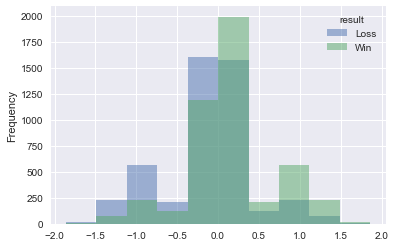

In [262]:
vis.pivot(values='Striking', columns='result').plot.hist(stacked=False, alpha=0.5)
plt.show()